In [1]:
import numpy as np
import os
import configparser
import cv2
import random


from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras import models
from keras.models import model_from_json

import sys
sys.path.insert(0, './lib/')
from help_functions import *
#function to obtain data for training/testing (validation)
from extract_patches import get_data_training


Using TensorFlow backend.


## Model init block


In [2]:
def unet(n_ch,patch_height,patch_width):
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = layers.Dropout(0.2)(conv1)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    #
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = layers.Dropout(0.2)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = layers.Dropout(0.2)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([conv2,up1],axis=1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = layers.Dropout(0.2)(conv4)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([conv1,up2], axis=1)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = layers.Dropout(0.2)(conv5)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    sgd = SGD(lr=0.000001, decay=1e-6, momentum=0.0, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [3]:
#for batch normalization
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = layers.Conv2D(filters=n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer= 'he_normal',
                     padding = 'same',data_format='channels_first')(input_tensor)
    
    if batchnorm ==True:
        x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer= 'he_normal',
                     padding = 'same',data_format='channels_first')(x)
    if batchnorm ==True:
        x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    return x
    

In [4]:
def unet_norm(n_ch,patch_height,patch_width):
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = conv2d_block(inputs, n_filters= 32, kernel_size=3, batchnorm=True)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    #
    conv2 = conv2d_block(pool1, n_filters= 64, kernel_size=3, batchnorm=True)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #
    
    
    conv3 = conv2d_block(pool2, n_filters= 128, kernel_size=3, batchnorm=True)
    
    
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([conv2,up1],axis=1)
    
    
    conv4 = conv2d_block(up1, n_filters= 64, kernel_size=3, batchnorm=True) 
    
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([conv1,up2], axis=1)
    conv5 = conv2d_block(up2, n_filters= 32, kernel_size=3, batchnorm=True)
    
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.1, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [5]:
def unet_norm2(n_ch,patch_height,patch_width):
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = conv2d_block(inputs, n_filters= 32, kernel_size=3, batchnorm=True)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    #
    
    conv2 = conv2d_block(pool1, n_filters= 64, kernel_size=3, batchnorm=True)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #
    up1 = layers.UpSampling2D(size=(2, 2))(conv2)
    up1 = layers.concatenate([conv1,up1],axis=1)
    
    
    conv5 = conv2d_block(up1, n_filters= 32, kernel_size=3, batchnorm=True)
    
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

## Load Configuration block


In [6]:
config = configparser.RawConfigParser()
config.read('conj_configuration.txt')

path_imgs = config.get('data paths', 'conj_path_img')
path_ground_truth = config.get('data paths', 'conj_path_ground')
name_experiment = config.get('experiment name', 'name')
num_epochs = int(config.get('training settings', 'num_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

fine_tuning_flag = config.get('fine tuning', 'fine_tuning')
pretrained_dir = config.get('fine tuning', 'pretrained_dir')

best_last = config.get('testing settings', 'best_last')



## Prepare conj data block

### Data information  
    ch : 1ch (gray level)  
    size : All diffent. shit  
    information : Conjunctival data from slit lamp. (just one person.)  

Enter 1 to select train_01.png
[DEBUG] shape of imgs :  (1000, 1300, 3) 

Enter 2 to select train_02.png
[DEBUG] shape of imgs :  (800, 1400, 3) 

Enter 3 to select train_03.png
[DEBUG] shape of imgs :  (380, 700, 3) 

Enter 4 to select train_04.png
[DEBUG] shape of imgs :  (650, 1200, 3) 

Enter 5 to select train_05.png
[DEBUG] shape of imgs :  (870, 463, 3) 

Enter 6 to select train_06.png
[DEBUG] shape of imgs :  (750, 1300, 3) 

Enter 1 to select train_conj_01.png
[DEBUG] shape of ground truth :  (1000, 1300) 

Enter 2 to select train_conj_02.png
[DEBUG] shape of ground truth :  (800, 1400) 

Enter 3 to select train_conj_03.png
[DEBUG] shape of ground truth :  (380, 700) 

Enter 4 to select train_conj_04.png
[DEBUG] shape of ground truth :  (650, 1200) 

Enter 5 to select train_conj_05.png
[DEBUG] shape of ground truth :  (870, 463) 

Enter 6 to select train_conj_06.png
[DEBUG] shape of ground truth :  (750, 1300) 



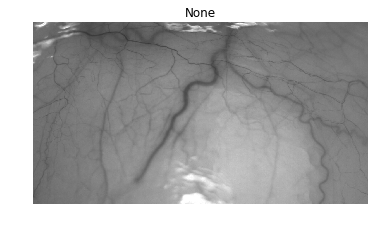

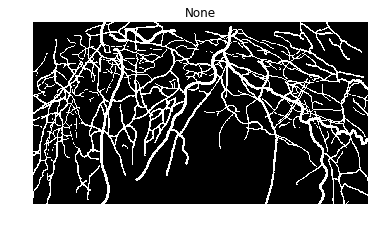

In [7]:
img_shape_list = []
img_list= []
ground_list =[]

# get image's size
for count, filename in enumerate(sorted(os.listdir(path_imgs)), start=1):
    print('Enter {} to select {}'.format(count, filename))
    tempImg = cv2.imread(path_imgs + filename)
    print('[DEBUG] shape of imgs : ', np.shape(tempImg), '\n')
    img_list.append(tempImg)
    
for count, filename in enumerate(sorted(os.listdir(path_ground_truth)), start=1):
    print('Enter {} to select {}'.format(count, filename))
    tempImg = cv2.imread(path_ground_truth + filename,0)
    print('[DEBUG] shape of ground truth : ', np.shape(tempImg),'\n')
    ground_list.append(tempImg)
    
img_list = np.array(img_list)
show_on_jupyter(img_list[3], color = 'gray')
show_on_jupyter(ground_list[3],color = 'gray')

In [8]:
if os.path.isdir('./'+'Result/'+name_experiment) == False:
    os.mkdir('./'+'Result/'+name_experiment)
else:
    print('already exist the folder in this path : {}'.format('./'+'Result/'+name_experiment))

already exist the folder in this path : ./Result/conjunctival_test_result


## Data preprocessing

In [9]:
def conj_preprocessing(img_list):
    preprocessed_img = img_list.copy()
    
    for i in range(len(img_list)):
        '''
        RGB to gray
        '''
        preprocessed_img[i] = preprocessed_img[i][:,:,0] * 0.299 + preprocessed_img[i][:,:,1]* 0.587+preprocessed_img[i][:,:,2]*0.114
        
        #DEBUG block
        #show_on_jupyter(preprocessed_img[i],'gray')
        #print('[1]', np.shape(preprocessed_img[i]))
        
        '''
        Dataset_normlaized
        '''
        imgs_normalized = np.empty(preprocessed_img[i].shape)
        imgs_std = np.std(preprocessed_img[i])
        imgs_mean = np.mean(preprocessed_img[i])
        preprocessed_img[i] = (preprocessed_img[i]-imgs_mean)/imgs_std
        preprocessed_img[i] = ((preprocessed_img[i] - np.min(preprocessed_img[i])) / (np.max(preprocessed_img[i])-np.min(preprocessed_img[i])))*255
    
        #show_on_jupyter(preprocessed_img[i],'gray')
        #print('[2]', np.shape(preprocessed_img[i]))
        '''
        Clahe eqaulized
        
        '''
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        preprocessed_img[i] = clahe.apply(np.array(preprocessed_img[i], dtype = np.uint8))
        
        #show_on_jupyter(preprocessed_img[i],'gray')
        #print('[3]', np.shape(preprocessed_img[i]))
        '''
        Adjust gamma
        
        '''
        gamma = 1.2
        
        invGamma = 1.0 / gamma
        table = np.array([((j / 255.0) ** invGamma) * 255 for j in np.arange(0, 256)]).astype("uint8")
        # apply gamma correction using the lookup table
        preprocessed_img[i] = cv2.LUT(np.array(preprocessed_img[i], dtype = np.uint8), table)
        #print('[4]', np.shape(preprocessed_img[i]))
        #show_on_jupyter(preprocessed_img[i],'gray')
        
        preprocessed_img[i] = preprocessed_img[i] / 255.
        #show_on_jupyter(preprocessed_img[i],'gray')
        #print(np.max(preprocessed_img[i]))
        #print('[5]', np.shape(preprocessed_img[i]))
    return preprocessed_img


prerprocessed_img_list = conj_preprocessing(img_list)


In [10]:
def extract_random(full_imgs,full_masks, patch_h,patch_w, num_patches):
    
    patches = np.empty((num_patches, 1 , patch_h, patch_w))
    patches_masks = np.empty((num_patches, 1 , patch_h, patch_w))
    
    print('[extract random] patches shape : {}'.format(patches.shape))
    
    
    for i in range(len(full_imgs)):  # loop, number of image samples
        
        img_h = full_imgs[i].shape[0]
        img_w = full_imgs[i].shape[1]

        patch_per_img =int(num_patches / len(full_imgs)) #ex, 48 / 20
        
        print('[extract random] patches per full image : {}'.format(patch_per_img))
        
        iter_total =0 #iter over the total number of patches (num_patches)
        k =0
        
        while k<patch_per_img: #iter, number of patch per img
            x_center = random.randint(0+int(patch_w/2) , img_w-int(patch_w/2))
            y_center = random.randint(0+int(patch_w/2) , img_h-int(patch_w/2))
            #print('[extract random] x_center : {}'.format(x_center))
            #print('[extract random] y_center : {}'.format(y_center))
            
            
            patch = full_imgs[i][y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)] #cropping
            patch_mask = full_masks[i][y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            #print('[extract random] patch y : {} to {}'.format(y_center-int(patch_h/2),y_center+int(patch_h/2) ))
            #print('[extract random] patch size : {}'.format(np.shape(patch)))
            #show_on_jupyter(patch,'gray')
            #show_on_jupyter(patch_mask,'gray')
            patches[iter_total]=patch
            patches_masks[iter_total]=patch_mask
            iter_total +=1   #total
            k+=1  #per full_img
            
    return patches, patches_masks

save_path = name_experiment
if os.path.isdir(save_path) == False:
    os.mkdir(save_path)
else:
    print('already exist the folder in this path : {}'.format(save_path))

    
# <===== Extract random patch ======>

patches_imgs_train, patches_masks_train = extract_random(prerprocessed_img_list, ground_list,
                        patch_h = int(config.get('data attributes', 'patch_height')),
                        patch_w = int(config.get('data attributes', 'patch_width')),
                        num_patches = int(config.get('training settings', 'num_subimgs')))

already exist the folder in this path : conjunctival_test_result
[extract random] patches shape : (5000, 1, 48, 48)
[extract random] patches per full image : 833
[extract random] patches per full image : 833
[extract random] patches per full image : 833
[extract random] patches per full image : 833
[extract random] patches per full image : 833
[extract random] patches per full image : 833


120
[group images func] prev data shape  : (120, 1, 48, 48)
[group images func] after data shape :  (120, 48, 48, 1)
[group images func] first total image :  (48, 240, 1)
[group images func] final total image :  (1200, 240, 1)
data shape :  (1200, 240, 1)
<PIL.Image.Image image mode=L size=240x1200 at 0x7F0F49FA1908>
file name :  ./conjunctival_test_result/sample_input_imgs
[group images func] prev data shape  : (120, 1, 48, 48)
[group images func] after data shape :  (120, 48, 48, 1)
[group images func] first total image :  (48, 240, 1)
[group images func] final total image :  (1200, 240, 1)
data shape :  (1200, 240, 1)
<PIL.Image.Image image mode=L size=240x1200 at 0x7F0F49F32E80>
file name :  ./conjunctival_test_result/sample_input_masks


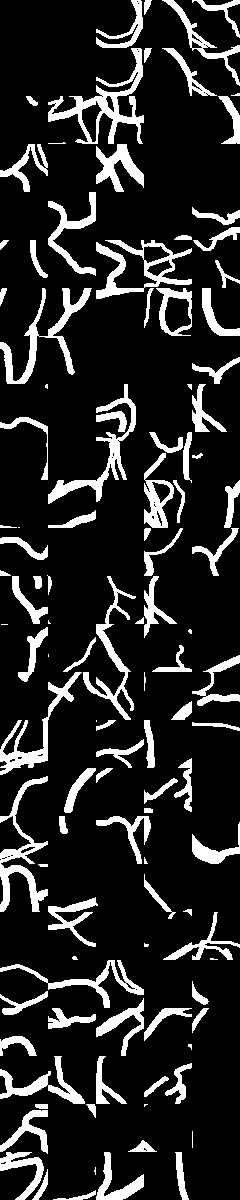

In [11]:
N_sample = min(patches_imgs_train.shape[0],120)
print(N_sample)
visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),'./'+name_experiment+'/'+"sample_input_imgs")#.show()
visualize(group_images(patches_masks_train[0:N_sample,:,:,:],5),'./'+name_experiment+'/'+"sample_input_masks")#.show()

## Train block  
###  Fine tuning block  
U-Net fine tuning  
  |_ DRIVE dataset (Pretrained)  
  |_ Conjunctival dataset (Fine tuning)


In [12]:
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]

if fine_tuning_flag=="False":
    print ("entered unet")
    model = unet_norm(n_ch, patch_height, patch_width)  #the U-net model
    plot(model, to_file='./'+name_experiment+'/' + '_model.png')   #check how the model looks like
    json_string = model.to_json()
    open('./'+name_experiment+'/'+'_architecture.json', 'w').write(json_string)

elif fine_tuning_flag=="True":
    # --------------------Fine tuning while training -----------------
    print ("About to load the pre trained model for fine tuning")
    model = model_from_json(open('./'+ pretrained_dir + '/' + pretrained_dir +'_architecture.json').read())
    model.load_weights('./'+ pretrained_dir + '/' +best_last+'_weights.h5')
    print ("loaded the pre trained model \n\n")


    for layer in model.layers[:]:
        if layer.name =='conv2d_11':
            layer.trainable = True
            print (layer.name,'\t',"Trainable layer")
        else :
            layer.trainable = False
        
        print (layer.name,'\t',"these layers wont be trained")
    
    ''' 
    for layer in model.layers[17:25]:
        layer.trainable = False
        print (layer.name,'\t',"these layers wont be trained")
    '''

    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    
#print model.layers
print ("Check: final output of the network:")
print (model.output_shape)
print(model.summary())






About to load the pre trained model for fine tuning
loaded the pre trained model 


input_1 	 these layers wont be trained
conv2d_1 	 these layers wont be trained
batch_normalization_1 	 these layers wont be trained
activation_1 	 these layers wont be trained
conv2d_2 	 these layers wont be trained
batch_normalization_2 	 these layers wont be trained
activation_2 	 these layers wont be trained
max_pooling2d_1 	 these layers wont be trained
conv2d_3 	 these layers wont be trained
batch_normalization_3 	 these layers wont be trained
activation_3 	 these layers wont be trained
conv2d_4 	 these layers wont be trained
batch_normalization_4 	 these layers wont be trained
activation_4 	 these layers wont be trained
max_pooling2d_2 	 these layers wont be trained
conv2d_5 	 these layers wont be trained
batch_normalization_5 	 these layers wont be trained
activation_5 	 these layers wont be trained
conv2d_6 	 these layers wont be trained
batch_normalization_6 	 these layers wont be trained
activ

In [13]:
print(int(config.get('training settings', 'num_subimgs')))

5000


###  Model training block

In [ ]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example
'''

checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

print('[training session] before mask unet func patch mask shape : ',patches_masks_train.shape)
patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
print('[training session] after mask unet func patch mask shape : ',patches_masks_train.shape)


history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.5, callbacks=[checkpointer])
model.save_weights('./'+name_experiment +'/last_weights.h5', overwrite=True)


[training session] before mask unet func patch mask shape :  (5000, 1, 48, 48)
[training session] after mask unet func patch mask shape :  (5000, 2304, 2)
Train on 2500 samples, validate on 2500 samples
Epoch 1/20
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1115 - acc: 0.9636 - val_loss: 1.0152e-04 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00010, saving model to ./conjunctival_test_result/best_weights.h5
Epoch 2/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1070 - acc: 0.9640 - val_loss: 1.6042e-04 - val_acc: 1.0000

Epoch 00002: val_loss did not improve from 0.00010
Epoch 3/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1035 - acc: 0.9642 - val_loss: 2.3222e-04 - val_acc: 1.0000

Epoch 00003: val_loss did not improve from 0.00010
Epoch 4/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1017 - acc: 0.9643 - val_loss: 3.1448e-04 - val_acc: 1.0000

Epoch 00004: val_loss did no

In [ ]:
print(history.history)


In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig(name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training accuracy")
plt.plot(epochs, val_acc, 'r', label = "Validation accuracy")
plt.title("Training and Validation acc")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig(name_experiment+"/training_acc_result.png")
plt.show()